<a href="https://colab.research.google.com/github/AndrewWalker251/bulb_classifier/blob/master/bulb_object_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [4]:
! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 2.7MB/s 
     |████████████████████████████████| 952kB 10.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=5dca09b921a726972d39f0d010221a21f34497ebb4c2e17756c7e259f8744b84
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [5]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import ast
import torch
import torchvision
import cv2
from torchvision import transforms, datasets
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import SubsetRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader, Dataset

%matplotlib inline

from google.colab.patches import cv2_imshow

In [6]:
# Labelbox data, convert to access required data (bounding box and class)
# Only set up to work for one object per image. 
object_labels = pd.read_csv('lightbulb_data/bulb_labels.csv')
df1 = pd.DataFrame(object_labels['Label'].apply(ast.literal_eval).values.tolist())
df2 = pd.DataFrame(df1['objects'].values.tolist())
df3 = pd.DataFrame(df2[0].values.tolist())
df4 = pd.DataFrame(df3['bbox'].values.tolist())
df = pd.concat([df4, df3['value'] ,object_labels['External ID']],axis=1)

In [7]:
df.head()

,top,left,height,width,value,External ID
0,1321,1626,779,674,b22,MVIMG_20200911_164611.jpg
1,1620,1071,933,899,b22,MVIMG_20200911_164636.jpg
2,1637,1204,625,695,b22,MVIMG_20200911_164706.jpg
3,1153,1248,440,572,b22,IMG_20200911_164514.jpg
4,1329,1257,608,669,b22,IMG_20200911_164718.jpg


In [8]:
# convert to float for compatability with pytorch model
df['top'] = df['top'].astype(np.float)
df['left'] = df['left'].astype(np.float)
df['height'] = df['height'].astype(np.float)
df['width'] = df['width'].astype(np.float)

In [9]:
# Modify Pytorch dataset class for object detection 

class BulbDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms):
        super().__init__()
        
        self.image_ids = dataframe['External ID'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[self.df['External ID'] ==image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        
        # How many classes are there
        num_objs = len(self.df['value'].unique())
        
        # Box coordinates
        boxes = records[['left', 'top','width', 'height']].values
        area = boxes[:,2] * boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # convert to corners of box
        boxes[:,2] = boxes[:,0] + boxes[:,2]
        boxes[:,3] = boxes[:,1] + boxes[:,3]
        
        # Convert into tensors
        #boxes = torch.as_tensor(boxes, dtype = torch.float32)
        
        # TODO this is only for one class.
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['area']= area
        
        if self.transforms:
            #image, target = self.transforms(image, target)
            sample = {
                'image':image,
                'bboxes':target['boxes'],
                'labels':labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0).float()


        return image, target
        
    def __len__(self):
        return self.image_ids.shape[0]
        

In [10]:
# Albumentations library for transfors.
def get_transforms():
    return A.Compose([
        A.Resize(200, 300),
        ToTensorV2(p=1.0)], bbox_params = {'format':'pascal_voc', 'label_fields': ['labels']})


In [11]:
df.head()

,top,left,height,width,value,External ID
0,1321.0,1626.0,779.0,674.0,b22,MVIMG_20200911_164611.jpg
1,1620.0,1071.0,933.0,899.0,b22,MVIMG_20200911_164636.jpg
2,1637.0,1204.0,625.0,695.0,b22,MVIMG_20200911_164706.jpg
3,1153.0,1248.0,440.0,572.0,b22,IMG_20200911_164514.jpg
4,1329.0,1257.0,608.0,669.0,b22,IMG_20200911_164718.jpg


In [12]:
mybulbloader = BulbDataset(df, r'lightbulb_data/own_pictures', get_transforms())

In [13]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [14]:
def create_separate_train_dev_test( dataset, percentages = [0.8,0.1,0.1]):
    '''
    Function to create separate dataloaders for test dev and train.
    
    Inputs - list of percentage breakdowns [train, dev , test] Must add to 1. 
    # Add in test to check for this ~
    
    Outputs - each dataloader.
    
    '''

    indices = list(range(len(dataset)))
    train_amount =0.8
    dev = 0.1
    test = 0.1

    split_1 = int(np.floor(len(dataset)*0.8))
    split_2 = int(np.floor(len(dataset)*0.9))

    np.random.seed(0)
    np.random.shuffle(indices)

    train_indices, dev_indices, test_indices = indices[:split_1], indices[split_1:split_2],indices[split_2:]

    train_sampler = SubsetRandomSampler(train_indices)
    dev_sampler = SubsetRandomSampler(dev_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    dataloader_train = torch.utils.data.DataLoader(dataset,
                                                 batch_size=2,
                                                 num_workers=0 , sampler = train_sampler, collate_fn = collate_fn)

    dataloader_dev = torch.utils.data.DataLoader(dataset,
                                                 batch_size=2,
                                                 num_workers=0 , sampler = dev_sampler, collate_fn = collate_fn)

    dataloader_test = torch.utils.data.DataLoader(dataset,
                                                 batch_size=2,
                                                 num_workers=0 , sampler = test_sampler,collate_fn = collate_fn)
    
    return dataloader_train, dataloader_dev, dataloader_test

In [15]:
dataloader_train, dataloader_dev, dataloader_test = create_separate_train_dev_test( mybulbloader, percentages = [0.8,0,0.2])

In [16]:
len(dataloader_train)

11

In [17]:
len(dataloader_test)

2

In [18]:



#dataloader_train = torch.utils.data.DataLoader(mybulbloader,
 #                                                batch_size=1,
 #                                                num_workers=0,
 #                                              )

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
images, targets = next(iter(dataloader_train))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [21]:
def plot_bulb_and_box(img, objects, idx):
  box = objects[idx]['boxes'].cpu().numpy().astype(np.int32)

  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  image = img[idx].permute(1,2,0).cpu().numpy()
  fig, ax = plt.subplots(1,1,figsize = (8,4))
  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'red', linewidth=3))
  ax.imshow(image)
  plt.show()

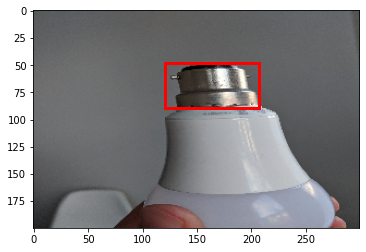

In [22]:
plot_bulb_and_box(images, targets, 1)

In [23]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [24]:
# Correct the head of the model for our domain 

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(in_features)

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

1024


In [25]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum =0.9, weight_decay=0.0005)


In [26]:
for epoch in range(2):
  for images, targets in dataloader_train:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    print(losses.item())

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


0.7111244201660156
0.27101045846939087
0.18541021645069122
0.24179291725158691
0.37648531794548035
0.30564308166503906
0.40900754928588867
0.3154886066913605
0.2570188641548157
0.2793697416782379
0.2480534166097641
0.24047087132930756
0.202317014336586
0.22062815725803375
0.21755248308181763
0.23417216539382935
0.22545504570007324
0.17274436354637146
0.18874675035476685
0.13103801012039185
0.15361614525318146
0.18377785384655


In [27]:
def plot_bulb_and_box_eval(img, objects,actual, idx):
  fig, ax = plt.subplots(1,1,figsize = (8,4))

  box = objects[idx]['boxes'].cpu().detach().numpy().astype(np.int32)

  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'red', linewidth=3))
  
  box = actual[idx]['boxes'].cpu().detach().numpy().astype(np.int32)

  xmin = box[0][0]
  ymin = box[0][1]
  xmax = box[0][2]
  ymax = box[0][3]

  ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color= 'green', linewidth=3))
  
  image = img[idx].permute(1,2,0).cpu().numpy()
  
  
  ax.imshow(image)
  plt.show()

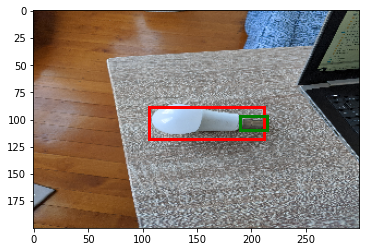

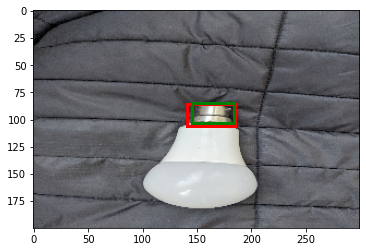

In [29]:
for images, actual in dataloader_test:
  images = list(image.to(device) for image in images)
  actual = [{k: v.to(device) for k, v in t.items()} for t in actual]

  model.eval()
  outputs = model(images)
  outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
  plot_bulb_and_box_eval(images, outputs,actual, 0)

In [ ]:
plot_bulb_and_box_eval(images, outputs,actual, 1)